<a href="https://colab.research.google.com/github/kaushikbar/spark/blob/master/04_06/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge

## Download and install Spark

In [1]:
!ls

police-station.csv   sample_data		spark-2.3.1-bin-hadoop2.7.tgz
reported-crimes.csv  spark-2.3.1-bin-hadoop2.7	spark-warehouse


In [0]:
#!apt-get update
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
#!tar xf spark-2.3.1-bin-hadoop2.7.tgz
#!pip install -q findspark

## Setup environment

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

## Downloading and preprocessing Chicago's Reported Crime Data

In [0]:
#!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
#!ls -l

In [0]:
#!mv rows.csv\?accessType\=DOWNLOAD reported-crimes.csv
#!ls -l

In [3]:
from pyspark.sql.functions import to_timestamp,col,lit
rc = spark.read.csv('reported-crimes.csv',header=True).withColumn('Date',to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') <= lit('2018-11-11'))
rc.show(5)

+-------+-----------+-------------------+--------------------+----+-----------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|     ID|Case Number|               Date|               Block|IUCR|     Primary Type|      Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+-------+-----------+-------------------+--------------------+----+-----------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|4968078|   HM580684|2006-09-04 09:32:56| 005XX S FRANKLIN ST|1350|CRIMINAL TRESPASS|TO STATE SUP LAND|               OTHER|  true|   false|0131|   

## Challenge questions

**What is the most frequently reported non-criminal activity?**

In [4]:
rc.cache()
rc.count()

6749332

In [5]:
rc.select(col('Primary Type')).distinct().count()

35

In [7]:
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(35, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN       |
|OTHER NARCOTIC VIOLATION   

In [8]:
nc = rc.filter( (col('Primary Type')=='NON - CRIMINAL') | (col('Primary Type')=='NON-CRIMINAL') | (col('Primary Type')=='NON-CRIMINAL (SUBJECT SPECIFIED)') )
nc.show(50)

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| 9747851|   HX397681|2010-07-22 09:00:00| 048XX N SHERIDAN RD|5093|        NON-CRIMINAL|       LOST PASSPORT|           RESIDE

In [9]:
nc.groupBy(col('Description')).count().orderBy('count', ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |109  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|CONCEALED CARRY LICENSE REVOCATION         |5    |
|FOUND PASSPORT                             |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



**Using a bar chart, plot which day of the week has the most number of reported crime. 
**

In [0]:
from pyspark.sql.functions import dayofweek

In [11]:
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col)
    Extract the day of the week of a given date as integer.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]
    
    .. versionadded:: 2.3



In [12]:
rc.select(col('Date'), dayofweek(col('Date'))).show(5)

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2006-09-04 09:32:56|              2|
|2006-08-31 20:30:00|              5|
|2006-09-03 04:30:00|              1|
|2006-09-03 22:30:00|              1|
|2006-09-05 00:00:00|              3|
+-------------------+---------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import date_format

In [14]:
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date, format)
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of the Java class `java.text.SimpleDateFormat` can be used.
    
    .. note:: Use when ever possible specialized functions like `year`. These benefit from a
        specialized implementation.
    
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(date_format('dt', 'MM/dd/yyy').alias('date')).collect()
    [Row(date='04/08/2015')]
    
    .. versionadded:: 1.5



In [15]:
rc.select(col('Date'), dayofweek(col('Date')), date_format(col('Date'), 'E')).show(5)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2006-09-04 09:32:56|              2|                 Mon|
|2006-08-31 20:30:00|              5|                 Thu|
|2006-09-03 04:30:00|              1|                 Sun|
|2006-09-03 22:30:00|              1|                 Sun|
|2006-09-05 00:00:00|              3|                 Tue|
+-------------------+---------------+--------------------+
only showing top 5 rows



In [16]:
rc.groupBy(date_format(col('Date'), 'E')).count().orderBy('count', ascending=False).show()

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1016316|
|                 Wed| 973325|
|                 Tue| 967482|
|                 Sat| 964693|
|                 Thu| 963947|
|                 Mon| 952140|
|                 Sun| 911429|
+--------------------+-------+



In [17]:
rc.groupBy(date_format(col('Date'), 'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=911429),
 Row(date_format(Date, E)='Mon', count=952140),
 Row(date_format(Date, E)='Thu', count=963947),
 Row(date_format(Date, E)='Sat', count=964693),
 Row(date_format(Date, E)='Wed', count=973325),
 Row(date_format(Date, E)='Tue', count=967482),
 Row(date_format(Date, E)='Fri', count=1016316)]

In [0]:
dow = [x[0] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]
cnt = [x[1] for x in rc.groupBy(date_format(col('Date'), 'E')).count().collect()]

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
cp = pd.DataFrame({'Day_of_week': dow, 'Count': cnt})
cp.head(7)

,Count,Day_of_week
0,911429,Sun
1,952140,Mon
2,963947,Thu
3,964693,Sat
4,973325,Wed
5,967482,Tue
6,1016316,Fri


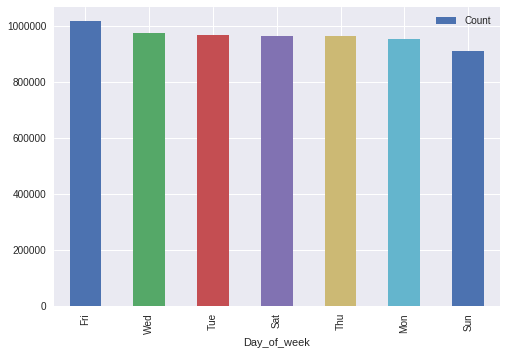

In [22]:
cp.sort_values('Count', ascending=False).plot(kind='bar', x='Day_of_week', y='Count');

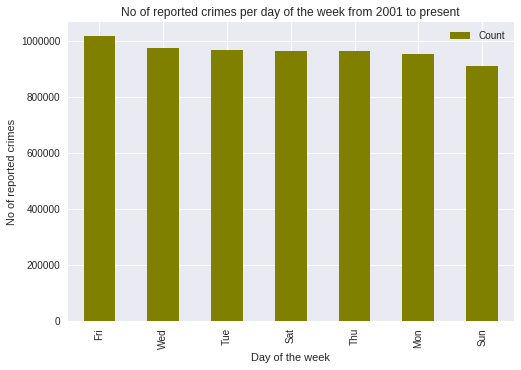

In [23]:
cp.sort_values('Count', ascending=False).plot(kind='bar', x='Day_of_week', y='Count', 
                                              color='olive')
plt.xlabel('Day of the week')
plt.ylabel('No of reported crimes')
plt.title('No of reported crimes per day of the week from 2001 to present');